In [1]:
import numpy as np
import random
import time

In [2]:
import sys
import os

In [3]:
import swyft
import torch
from pytorch_lightning.loggers import WandbLogger
import wandb

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
import IPython

In [6]:
import pickle

In [7]:
%matplotlib inline

In [8]:
files_name = "all_floor" + "_files"
parent_dir = (os.getcwd()+"/").split('/notebooks/', 1)[0]
start_dir = os.getcwd()
files_dir = os.getcwd() + "/" + files_name 
store_name = files_name.split("_files")[0] + "_store"
store_dir = os.getcwd() + "/" + files_name + "/" + store_name
sys.path.append(files_dir)

In [9]:
from ALP_quick_sim import ALP_sim

In [10]:
with open(files_dir+"/"+'config_objects.pickle', 'rb') as file:
    config_objects = pickle.load(file)
for key in config_objects.keys():
    locals()[key] = config_objects[key]

with open(files_dir+"/"+'obs_objects.pickle', 'rb') as file:
    obs_objects = pickle.load(file) 
for key in obs_objects.keys():
    locals()[key] = obs_objects[key]

with open(files_dir+"/"+'sim_objects.pickle', 'rb') as file:
    sim_objects = pickle.load(file)
for key in sim_objects.keys():
    locals()[key] = sim_objects[key]

In [11]:
marginals = [0]

# Load simulations again

In [12]:
store = swyft.ZarrStore(store_dir + "/" + store_name)
samples = store.get_sample_store()

In [13]:
len(samples)

100000

In [14]:
np.where(np.isinf(samples['data']))

(array([], dtype=int64), array([], dtype=int64))

In [15]:
inf_sims = np.where(np.isinf(samples['data']))
for i,inf_sim in enumerate(inf_sims[0]):
    samples['data'][inf_sim,inf_sims[1][i]] = samples['data'][inf_sim,inf_sims[1][i]-1]

Generating new null-hypothesis... done.


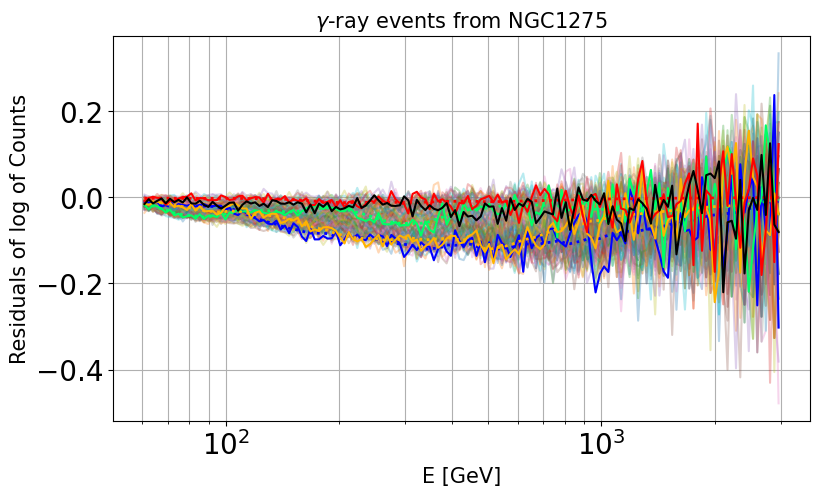

In [16]:
A.configure_plot(xmin=None, xmax=None, ymin=None,ymax=None,legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.7)


for i,obs in enumerate(observations):
    A.configure_model(params=obs['params'])
    A.import_counts(obs=obs['data'],exp=obs['exp'])
    shade = i/(len(observations)+1)
    A.compute_case(new_fig=0,new_counts=0,color='k',color_obs=colors[i],linestyle_obs="-",label_exp=0,label_obs=0,
                   errorbands=0, errors=0, plot_exp=0)
    A.compute_case(new_fig=0,new_counts=0,color=colors[i],color_obs=colors[i],linestyle=":",label_exp=0,label_obs=0,
                        errorbands=0, errors=0, plot_obs=0) 

A.import_counts(obs=samples['data'][96761,:],exp=samples['exp'][96761,:])
A.compute_case(new_fig=0,new_counts=0,color='k',color_obs='k',linestyle_obs="-",label_exp=0,label_obs=0,
               errorbands=0, errors=0, plot_exp=0)

# Train again

In [17]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.norm = swyft.networks.OnlineStandardizingLayer(torch.Size([A.nbins]), epsilon=0)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = A.nbins, 
            num_params = len(marginals), 
            varnames = A.param_names)
        self.learning_rate = 0.000005
    
    def forward(self, A, B):
        data = self.norm(A['data'])
        return self.logratios(data, B['params'][:,marginals])

In [18]:
network = Network()

In [19]:
wandb_logger = WandbLogger(log_model='all')

wandb: Currently logged in as: gertwkl (alps_with_swyft). Use `wandb login --relogin` to force relogin


In [20]:
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64, logger=wandb_logger #, min_epochs =25, 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
dm = swyft.SwyftDataModule(samples, num_workers = 4, on_after_load_sample = sim.get_resampler(targets = ['data']), batch_size=512)

In [22]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                     | Params
-------------------------------------------------------
0 | norm      | OnlineStandardizingLayer | 0     
1 | logratios | LogRatioEstimator_1dim   | 26.9 K
-------------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.216     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/taq0keeq/checkpoints/epoch=119-step=18840.ckpt


In [23]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▅▅▄▄▄▃▄▃▄▂▃▃▃▃▃▂▃▄▂▂▃▃▂▂▄▃▂▂▂▂▃▂▃▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,124
train_loss,-0.30044
trainer/global_step,19624
val_loss,-0.26315


In [24]:
torch.save(network.state_dict(),"trained_network_batch_10.pt")

# Infer again

In [25]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 157it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 157it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 157it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 157it [00:00, ?it/s]

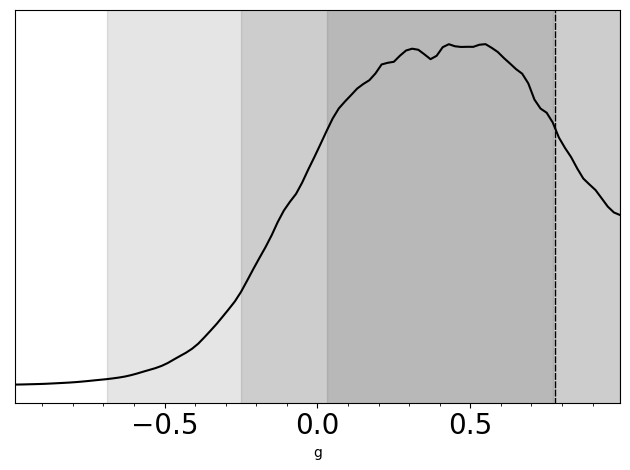

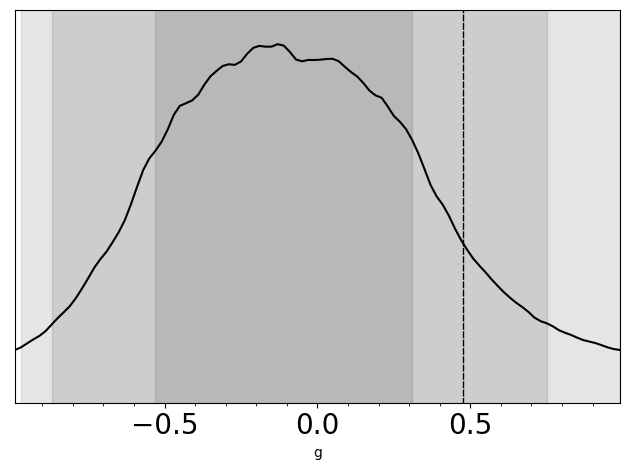

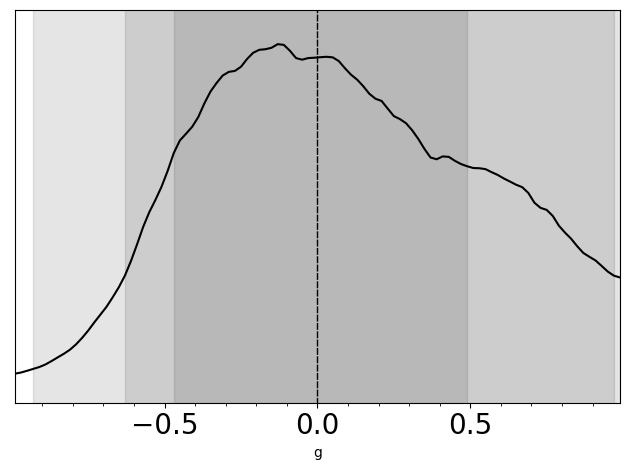

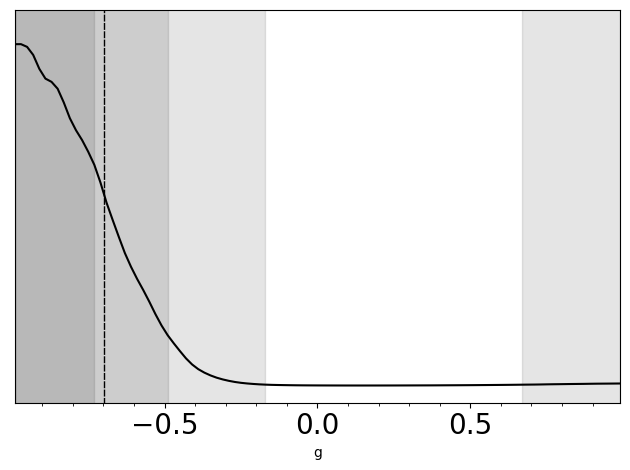

In [26]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            network,
                            observations[j],
                            prior_samples
                            )
    
    # swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})
    swyft.plot_posterior(logratios, A.param_names[0], truth={A.param_names[i]:truths[j][i] for i in range(1)},color_truth=colors[j])